In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # Loading dataset using keras libary

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
train_indices = np.random.choice(x_train.shape[0], 6000, replace=False)
x_train_subset = x_train[train_indices]
y_train_subset = y_train[train_indices]


test_indices = np.random.choice(x_test.shape[0], 1000, replace=False)
x_test_subset = x_test[test_indices]
y_test_subset = y_test[test_indices]

# Reducing train and test size due to taking to much time for train the model

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
y_test.shape

(10000,)

In [9]:
x_test.shape

(10000, 28, 28)

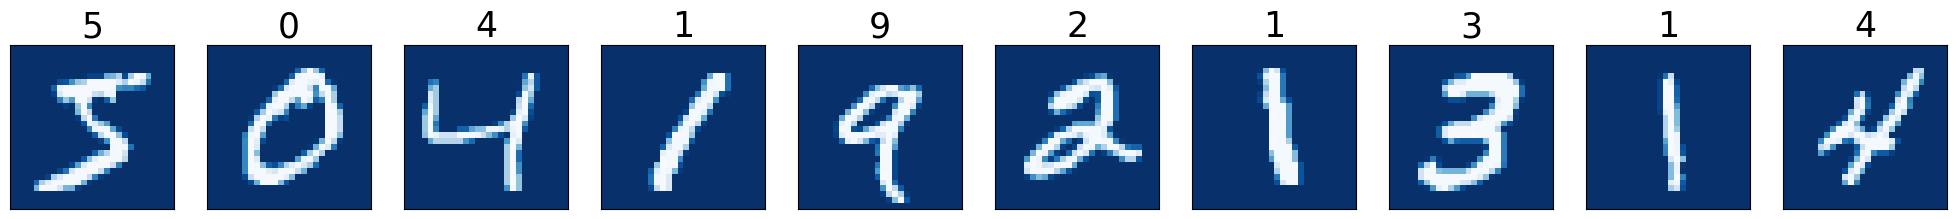

In [10]:
fig = plt.figure(figsize=(25, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(x_train[idx], cmap='Blues_r') # visualization of the sample
    ax.set_title(str(y_train[idx]),fontsize=25) # corresponding y value for the number
plt.show()
# Here is the visualization fo the first 10 sample of the dataset

In [14]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', random_state=42) # Initialize the SVC object

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

nsamples, nx, ny = x_train_subset.shape
x_train_2d = x_train_subset.reshape((nsamples,nx*ny))
# Reshape the data to compatible for SVC

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Using stratifiedKfold will give a more realistic and relevant train and test split
# In the Stratified version the distribution of the folds are equal to the main training set distribution and this will increase the accuracy of our model

cv = cross_val_score(svc, x_train_2d, y_train_subset, cv=skf, scoring='accuracy')
# cross validation takes some parameters in our example it takes the our classification model(estimator)
# getting training and test set and the cross validation generator in our example StratifiedKfold

base_best_accu = np.max(cv)
print(f"Maximum Accuracy: {base_best_accu}")
print(f"Minimum Accuracy: {np.min(cv)}")
# Prints the min and max accuracy

Maximum Accuracy: 0.9058333333333334
Minimum Accuracy: 0.8891666666666667


In [16]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
  "C": [0.1, 1, 10, 100],
  "gamma": ['scale', 'auto'],
  "kernel": ['linear', 'rbf', 'poly']
}
# Paramters to search best for SVC


rs = RandomizedSearchCV(svc, parameters, cv=skf, n_iter= 18, scoring='accuracy', random_state = 42, n_jobs=-1)
# The randomized search gets some parameters which is are our estimator the parameters which will search to fit best for our model
# n_iter is the number of combination of our parameters values, in our example it checks every combination of the parameters which is best for our model
# n_jobs indicate how much cpu core will use during the search -1 indicates all cores
rs.fit(x_train_2d, y_train_subset) # training the search to find the best parameters

rs_best_score = rs.best_score_
print(f"Best Accuracy: {rs_best_score}")
print(f"Best Parameters: {rs.best_params_}")

Best Accuracy: 0.9545
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


In [17]:
from sklearn.model_selection import GridSearchCV

parameters = {
  "C": [1, 10,],
  "gamma": ['scale', 'auto'],
  "kernel": ['rbf', 'poly']
}
# Taken the some of the parameters based on last search

gs = GridSearchCV(svc, parameters, cv=skf, scoring='accuracy', n_jobs=-1)
gs.fit(x_train_2d, y_train_subset) # training the model

gs_best_score = gs.best_score_
print(f"Best Accuracy: {gs_best_score}")
print(f"Best Parameters: {gs.best_params_}")

Best Accuracy: 0.9545
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [18]:
print(f"Baseline model accuracy: {base_best_accu}\nRandomizedSearchCV accuracy: {rs_best_score}\nGridSearchCV accuracy: {gs_best_score}")
# It is clearly visible that using search algorithm to find the best parameters give a higher accuracy than using default parameters.

Baseline model accuracy: 0.9058333333333334
RandomizedSearchCV accuracy: 0.9545
GridSearchCV accuracy: 0.9545


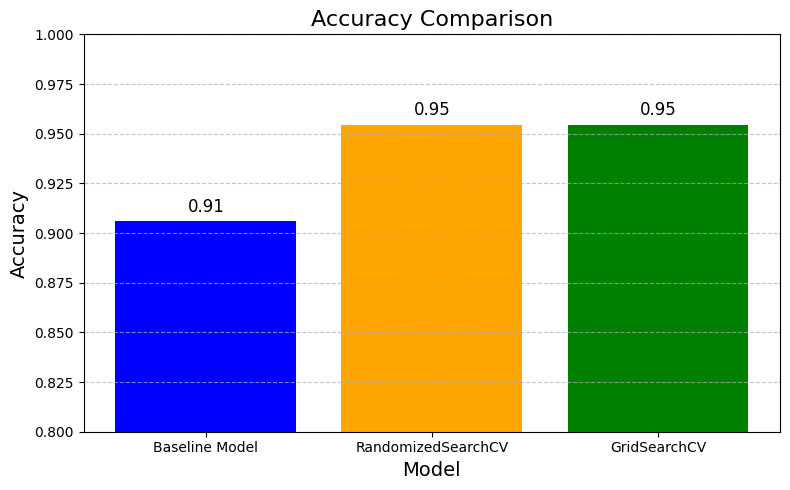

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Here is the visualization of the accuracy and comparison to the other searching algorithm and basedline model.

accuracies = [base_best_accu, rs_best_score, gs_best_score]
labels = ['Baseline Model', 'RandomizedSearchCV', 'GridSearchCV']

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])


for i, accu in enumerate(accuracies):
    plt.text(i, accu + 0.005, f"{accu:.2f}", ha='center', fontsize=12)

plt.title('Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.8, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

Accuracy: 0.975


Text(0.5, 1.0, 'Confusion Matrix of the Best Model')

<Figure size 1000x800 with 0 Axes>

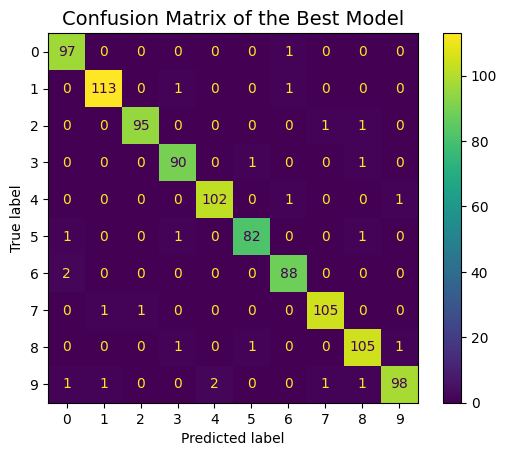

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


nsamples, nx, ny = x_test_subset.shape
x_test_2d = x_test_subset.reshape((nsamples,nx*ny)) # Again reshaping test set to compatible for svc

y_test_pred = gs.best_estimator_.predict(x_test_2d) # Predicting y values based on x test set using the best parameters for svc model
accuracy = accuracy_score(y_test_subset, y_test_pred) # Comparing the result of the real world y test set and prediction test set of y
print(f"Accuracy: {accuracy}")


cm = confusion_matrix(y_test_subset, y_test_pred) # Make a confusion matrix from y test set and y prediction set
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(10, 8))
disp.plot()
plt.title("Confusion Matrix of the Best Model", fontsize=14)